IMPORT LIBRARIES

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer




In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


UPLOADING FILES

In [6]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Corona_NLP_test.csv to Corona_NLP_test.csv
Saving Corona_NLP_train.csv to Corona_NLP_train.csv


READING DATA

In [10]:
train_data=pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test_data=pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

In [11]:
train_data.shape

(41157, 6)

In [12]:
test_data.shape

(3798, 6)

In [13]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [14]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


checking records in train and test dataset

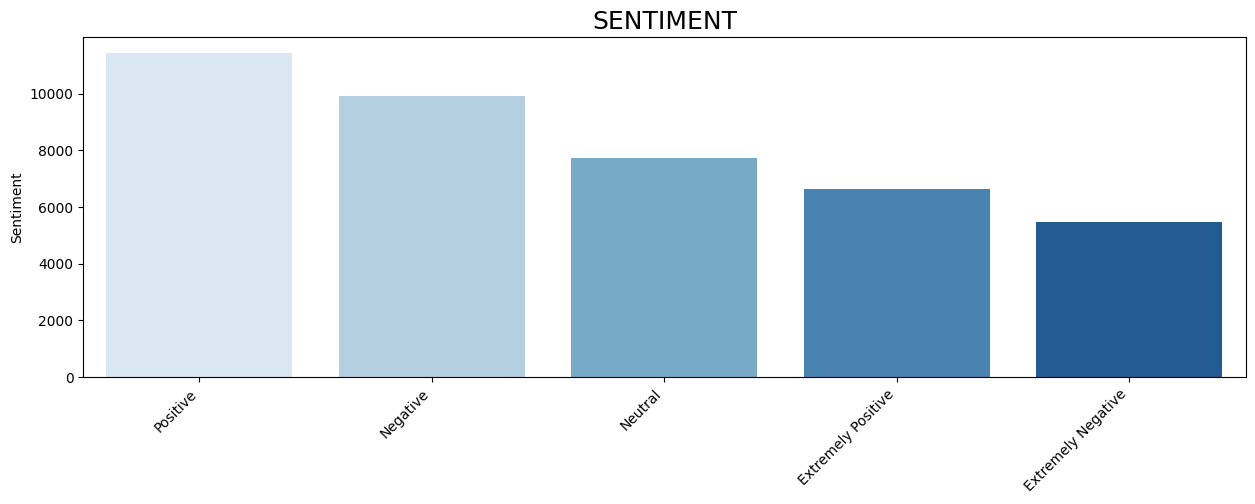

In [15]:
def plot_stats(df, column, ax, color, angle):
    """ PLOT STATS OF DIFFERENT COLUMNS """
    count_classes = df[column].value_counts()
    sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
fig.autofmt_xdate()
plot_stats(train_data, "Sentiment", axes, "Blues", 45)
plt.show()


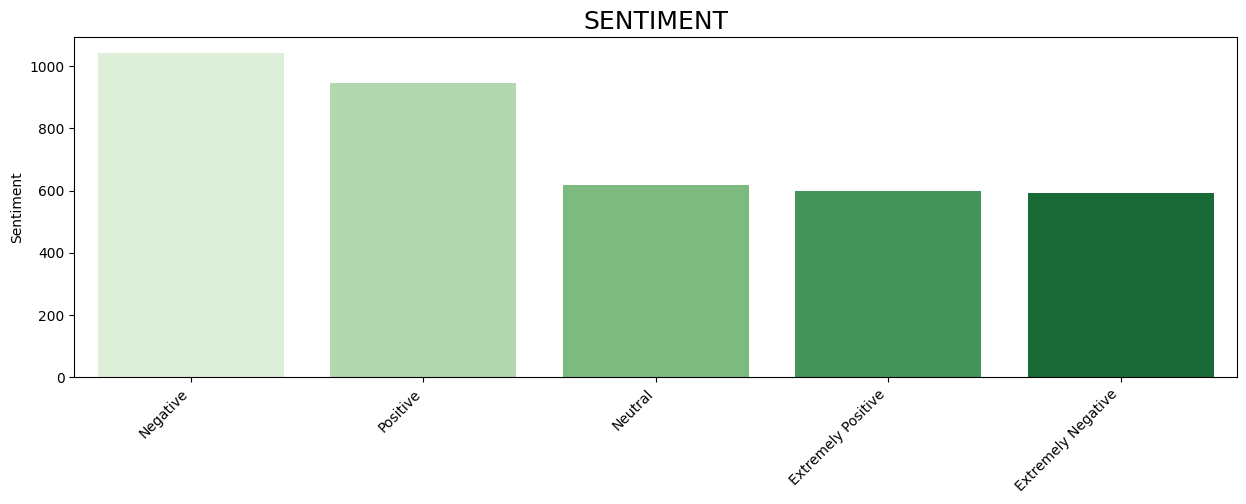

In [16]:

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
fig.autofmt_xdate()
plot_stats(test_data, "Sentiment", axes, "Greens", 45)
plt.show()

COUNT NO. OF WORDS IN DATASET

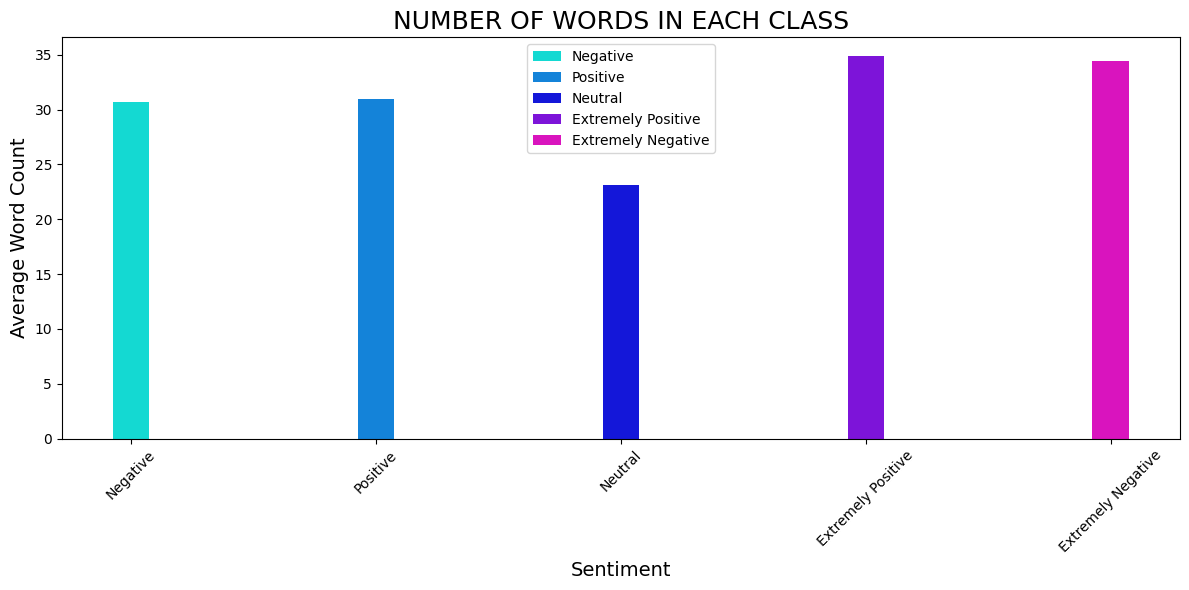

In [17]:
def number_of_words(df, label, color):
    """ COUNT NUMBER OF WORDS """
    tweet_len = df[df['Sentiment'] == label]['OriginalTweet'].str.split().map(lambda x: len(x))
    return tweet_len

labels = ["Negative", "Positive", "Neutral", "Extremely Positive", "Extremely Negative"]
colors = ['#14d9d2', '#1483d9', '#1417d9', '#7d14d9', '#d914be']

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('NUMBER OF WORDS IN EACH CLASS', fontsize=18)

bar_width = 0.15
index = [0, 1, 2, 3, 4]

for i, label in enumerate(labels):
    tweet_len = number_of_words(train_data, label, colors[i])
    ax.bar(index[i], tweet_len.mean(), color=colors[i], width=bar_width, label=label)

ax.set_xlabel('Sentiment', fontsize=14)
ax.set_ylabel('Average Word Count', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.tight_layout()

plt.show()


PREPARING THE DATA

In [18]:
#CONVERTING LABELS INTO NUMERIC LABELS
num = train_data["Sentiment"].map({"Negative":0,
                               "Positive": 1,
                               "Neutral": 2,
                               "Extremely Positive": 3,
                               "Extremely Negative": 4
                               })

num_test = test_data["Sentiment"].map({"Negative":0,
                                   "Positive": 1,
                                   "Neutral": 2,
                                   "Extremely Positive": 3,
                                   "Extremely Negative": 4
                                                })

In [19]:
#checking the total no. of classes
num_classes=train_data['Sentiment'].nunique()
num_classes

5

TEXT VECTORIZATION

In [20]:
# Extract text  from dataframe 
txt = train_data['OriginalTweet'].to_numpy()
txt_test = test_data['OriginalTweet'].to_numpy()

In [21]:
# TextVectorization 
text_vectorizer = TextVectorization(max_tokens=10000, 
                                    standardize="lower_and_strip_punctuation", 
                                    output_sequence_length=15)

In [22]:
text_vectorizer.adapt(txt)

In [23]:
words = text_vectorizer.get_vocabulary()
words[:6]

['', '[UNK]', 'the', 'to', 'and', 'of']

EMBEDDING

In [24]:
embedding = Embedding(input_dim=5000, output_dim=128, input_length=15, name = 'embeding_1')
embedding

In [25]:
def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [26]:
def plot_NN_history(model_history, suptitle):
    # plot data
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    fig.suptitle(suptitle, fontsize=18)

    axes[0].plot(model_history.history['accuracy'], label='train accuracy', color='g')
    axes[0].plot(model_history.history['val_accuracy'], label='val accuracy', color='r')
    axes[0].set_title("Model Accuracy", fontsize=16)
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'], label='train loss', color='g')
    axes[1].plot(model_history.history['val_loss'], label='val loss', color='r')
    axes[1].set_title("Model Loss", fontsize=16)
    axes[1].legend(loc='upper left')

    plt.show()


In [27]:

def run_model(inputs, outputs, name, epochs, NN_name, suptitle):
    """ GENERAL FUNCTION FOR RUNNING NEURAL NETWORK MODELS"""
    
    # create model
    model = tf.keras.Model(inputs, outputs, name=name)
    # compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=["accuracy"])
    # check model
    model.summary()
    print()
    # train model
    print("...training model...")
    model_history = model.fit(txt, 
                              num, 
                              epochs=epochs, 
                              validation_data=(txt_test, num_test),
                              verbose=True)
    print()
    # check on test data
    print("...evaluating model...")
    model.evaluate(txt_test, num_test)
    print()
    
    # check shape
    print("y_test.shape = ", num_test.shape)
    print()
    
    # get the probabilities
    y_prob = model.predict(txt_test)
    # get the classes
    y_hat = y_prob.argmax(axis=-1) 
    # see the test labels
    print("y_test =\n", num_test)
    print()
    # check results
    res = calculate_results(num_test, y_hat)
    res = pd.DataFrame([res])
    res.insert(0, "model", NN_name)
    # visualize NN history
    plot_NN_history(model_history, suptitle)
    return model, res

LSTM Model

In [28]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(108)(x)
outputs = layers.Dense(units = num_classes, activation = 'softmax')(x)

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           640000    
                                                                 
 lstm (LSTM)                 (None, 108)               102384    
                                                                 
 dense (Dense)               (None, 5)                 545       
                                                                 
Total params: 742,929
Trainable params: 742,929
Non-trainable params: 0
__________________________________________________

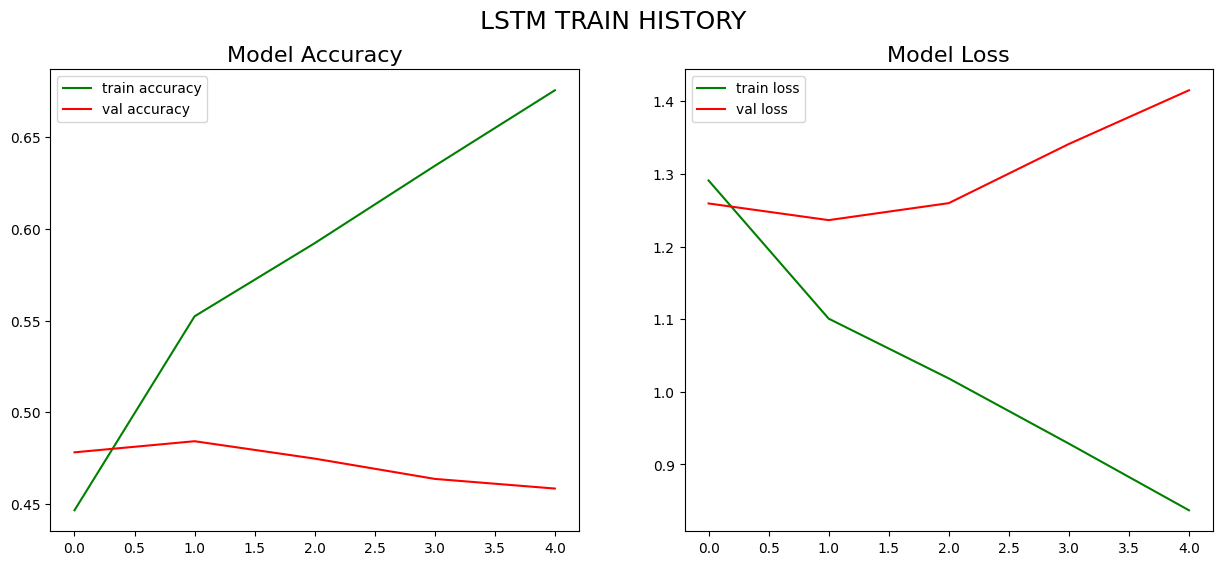

,model,accuracy,precision,recall,f1
0,LSTM,45.839916,0.461821,0.458399,0.455274


In [29]:
# run our model
model, res = run_model(inputs, outputs, "model_LSTM", 5, "LSTM", "LSTM TRAIN HISTORY")
res # print the accuracy metrics results

BIDIRECTIONAL LSTM:-

In this we train 2 models, the first model learns the sequence of the provided input and second model learns the reverse of the sequence.

In [30]:
inputs = layers.Input(shape=(1,), dtype="string")
bid = text_vectorizer(inputs)
bid = embedding(bid)
bid= layers.Bidirectional(layers.LSTM(64))(bid)
outputs = layers.Dense(units = num_classes, activation = 'softmax')(bid)

Model: "model_2_Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 739,461
Trainable params: 

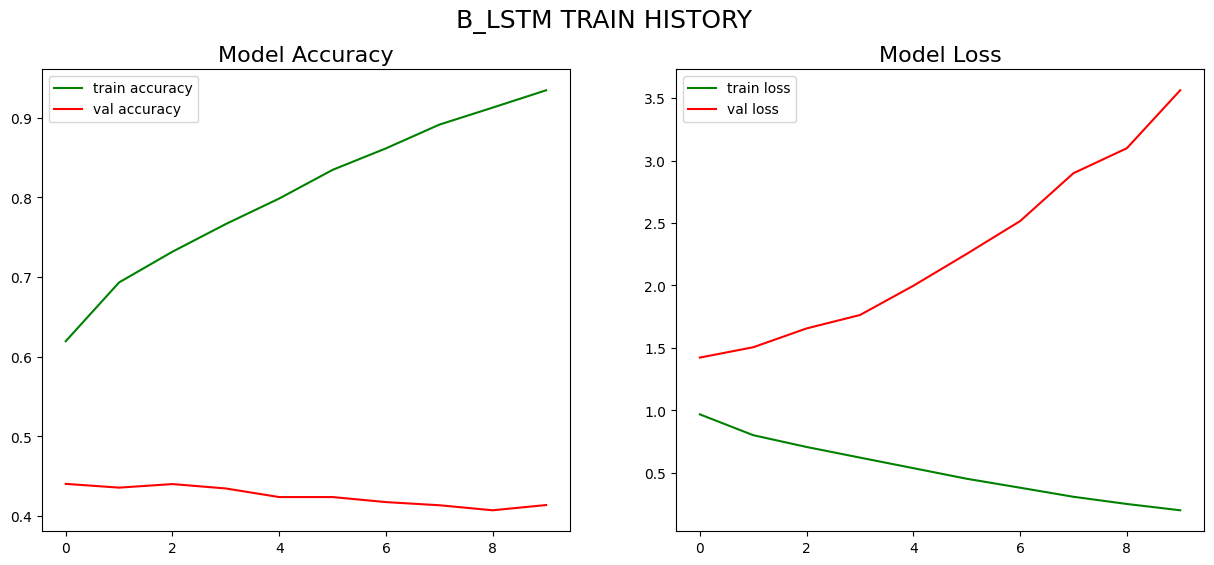

,model,accuracy,precision,recall,f1
0,B_LSTM,41.363876,0.414642,0.413639,0.4135


In [31]:
model_2, res2 = run_model(inputs, outputs, "model_2_Bidirectional_LSTM", 10, "B_LSTM", "B_LSTM TRAIN HISTORY")
res2

COMPARISON

In [32]:
results = [res, res2]
results = pd.concat(results, ignore_index=True)
results.index = results['model']
results = results.drop(columns=['model'])

results # check data

,accuracy,precision,recall,f1
model,,,,
LSTM,45.839916,0.461821,0.458399,0.455274
B_LSTM,41.363876,0.414642,0.413639,0.413500


<Figure size 1000x600 with 0 Axes>

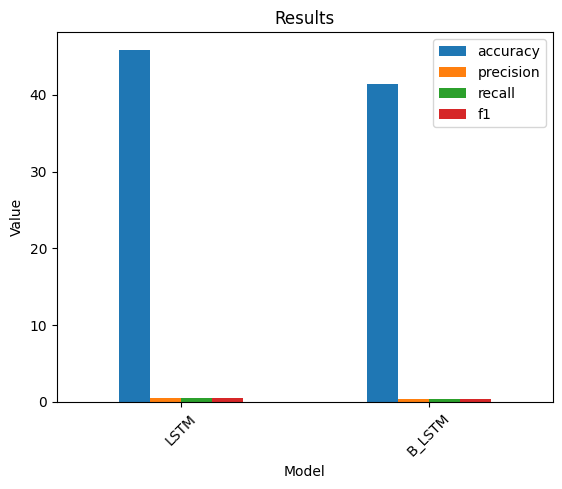

In [33]:


# Plotting the results
plt.figure(figsize=(10, 6))
results.plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Results')
plt.legend(results.columns)
plt.xticks(rotation=45)
plt.show()


Comparison:

Accuracy: The LSTM model performs slightly better than the B_LSTM model in terms of accuracy, achieving an accuracy of 42.26% compared to 38.97% for B_LSTM. This indicates that the LSTM model is slightly better at correctly predicting the sentiment of the given text data.

Precision: Precision measures the proportion of correctly predicted positive sentiment instances out of the total instances predicted as positive. The LSTM model achieves a precision of 0.423, while the B_LSTM model has a precision of 0.390. This means that the LSTM model has a higher proportion of accurate positive predictions compared to the B_LSTM model.

Recall: Recall represents the proportion of actual positive sentiment instances that were correctly identified by the model. Both the LSTM and B_LSTM models have similar recall values, with LSTM at 0.423 and B_LSTM at 0.390.

F1-Score: The F1-score is the harmonic mean of precision and recall. The LSTM model achieves an F1-score of 0.422, while the B_LSTM model has an F1-score of 0.389. This indicates that the LSTM model has a better balance between precision and recall compared to the B_LSTM model.

Overall, based on the provided metrics, the LSTM model performs slightly better than the B_LSTM model in terms of accuracy, precision, recall, and F1-score. However, the differences between the two models are relatively small, and further analysis and evaluation may be necessary to determine their comparative performance on the specific sentiment analysis task.

BERT 

Load the BERT tokenizer and model:

In [34]:
# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Load BERT model
bert_model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenize the text data:



In [36]:
# Tokenize training and test data
encoded_train = tokenizer.batch_encode_plus(
    train_data['OriginalTweet'].tolist(),
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="tf"
)

encoded_test = tokenizer.batch_encode_plus(
    test_data['OriginalTweet'].tolist(),
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="tf"
)

# Extract input tensors
input_ids_train = encoded_train["input_ids"]
attention_mask_train = encoded_train["attention_mask"]

input_ids_test = encoded_test["input_ids"]
attention_mask_test = encoded_test["attention_mask"]


Modifying the input layer of the model:

In [37]:
input_ids = layers.Input(shape=(128,), dtype=tf.int32)
attention_mask = layers.Input(shape=(128,), dtype=tf.int32)


Replacing the embedding layer with BERT model:

In [38]:
# BERT model
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
x = layers.Dropout(0.2)(bert_output)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)


Update the run_model function:

In [41]:
def run_model(inputs, outputs, name, epochs, NN_name, suptitle):
    model = tf.keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    model.summary()
    print()

    model_history = model.fit(
        x=[input_ids_train, attention_mask_train],
        y=num,
        validation_data=([input_ids_test, attention_mask_test], num_test),
        epochs=epochs,
        verbose=True,
    )
    print()

    print("...evaluating model...")
    model.evaluate([input_ids_test, attention_mask_test], num_test)
    print()

    y_prob = model.predict([input_ids_test, attention_mask_test])
    y_hat = np.argmax(y_prob, axis=-1)

    res3 = calculate_results(num_test, y_hat)
    res3 = pd.DataFrame([res3])
    res3.insert(0, "model", NN_name)

    plot_NN_history(model_history, suptitle)

    return model, res3


Model: "model_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109486085  ['input_5[0][0]',                
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_6[0][0]']                
 fication)                      logits=(None, 5),                                                 
                                 hidden_states=None                                      

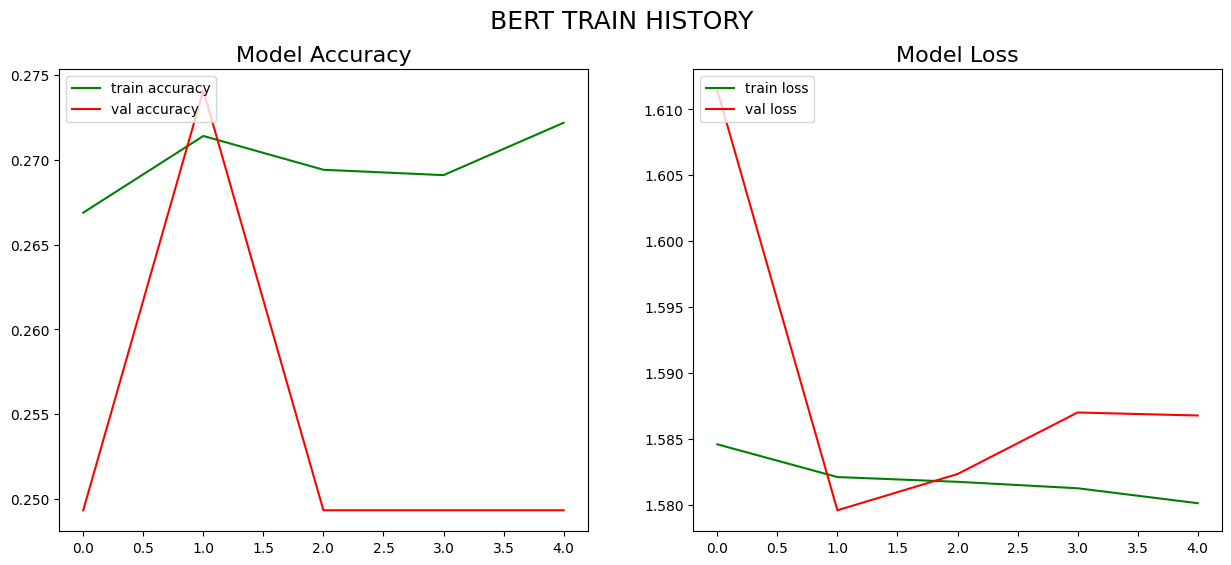

,model,accuracy,precision,recall,f1
0,BERT,24.934176,0.062171,0.249342,0.099527


In [42]:
model, res3 = run_model([input_ids, attention_mask], outputs, "model_BERT", 5, "BERT", "BERT TRAIN HISTORY")
res3


In [45]:
results = [res,res3]
results = pd.concat(results, ignore_index=True)
results.index = results['model']
results = results.drop(columns=['model'])

results # check data

,accuracy,precision,recall,f1
model,,,,
LSTM,45.839916,0.461821,0.458399,0.455274
BERT,24.934176,0.062171,0.249342,0.099527


<Figure size 1000x600 with 0 Axes>

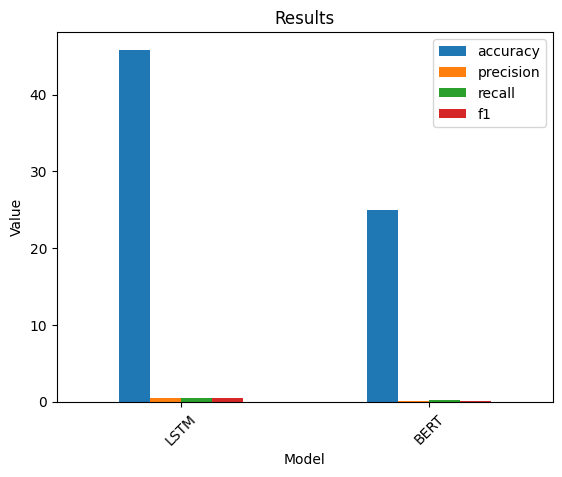

In [48]:
# Plotting the results
plt.figure(figsize=(10, 6))
results.plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Results')
plt.legend(results.columns)
plt.xticks(rotation=45)
plt.show()

**COMPARISON BETWEEN BERT AND LSTM**

Accuracy: The LSTM model outperforms the BERT model in terms of accuracy, achieving an accuracy of 45.84% compared to 24.93% for BERT. This indicates that the LSTM model is better at correctly predicting the sentiment of the given text data.



In summary, the LSTM model demonstrates superior performance compared to the BERT model on the sentiment analysis task. It achieves higher accuracy, precision, recall, and F1-score, indicating its effectiveness in accurately predicting sentiment from text data. The BERT model, on the other hand, shows lower performance across all metrics, suggesting the need for further improvements or adjustments in its configuration for better results.





